In [1]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, KFold
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import xgboost as xgb
import lightgbm as lgb

from imblearn.over_sampling import RandomOverSampler

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 9485

In [2]:
train_raw = pd.read_csv("../input/tabular-playground-series-aug-2022/train.csv", index_col='id')
test_raw = pd.read_csv("../input/tabular-playground-series-aug-2022/test.csv", index_col='id')

X_train = train_raw.drop(columns=['failure'])
X_sub = test_raw

y_train = train_raw['failure']

In [3]:
int_cols = [f for f in train_raw.columns if train_raw[f].dtype == int and f != 'failure']
float_cols = [f for f in train_raw.columns if train_raw[f].dtype == float]
categorical_cols = ['attribute_0', 'attribute_1']

In [4]:
def ohe(X_train, X_test, columns):
    transformer = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore', 
                       drop='first', 
                       categories=[['material_5', 'material_7'],
                                   ['material_5', 'material_6', 'material_8']]), columns),
        remainder='passthrough')

    X_train = pd.DataFrame(
        transformer.fit_transform(X_train), 
        columns=transformer.get_feature_names()
    )
    X_test = pd.DataFrame(
        transformer.transform(X_test),
        columns=transformer.get_feature_names()
    )
    
    return X_train, X_test

In [5]:
def impute_per_product_code(X, imputer):
    """Impute missing values in TPS2208 data.
    
    Imputation is performed over separate "per-product-code" batches, and is designed to leave all non-imputed 
    data in the exact same format as before imputation."""
    # source: https://www.kaggle.com/code/purist1024/per-product-code-imputation
    def transform(X):
        return pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)

    cats = ["product_code", "attribute_0", "attribute_1", "attribute_2", "attribute_3"]
    ints = ["measurement_0", "measurement_1", "measurement_2"]
    right = pd.concat([transform(gdf.drop(columns=cats)) for g, gdf in X.groupby("product_code")],
                      axis="rows")
    right[ints] = right[ints].round().astype(int)
    return pd.concat([X[cats], right], axis="columns").reindex(columns=X.columns)

def impute(X_train, X_test, imputer, columns):
    X_train[columns] = imputer.fit_transform(X_train[columns])
    X_test[columns] = imputer.transform(X_test[columns])
    
    return X_train, X_test

In [6]:
def oversample(X_train, y_train, oversampler):
    return oversampler.fit_resample(X_train, y_train)

In [7]:
def prepare_data(X_train, X_test, y_train, imputer, oversampler, per_product_code=False):
    if not per_product_code:
        print("Dropping product code...")
        X_train = X_train.drop(columns=['product_code'], axis=1)
        X_test = X_test.drop(columns=['product_code'], axis=1)
    
    if imputer != None:
        print("Imputing...")
        if per_product_code:
            X_train = impute_per_product_code(X_train, imputer)
            X_test = impute_per_product_code(X_test, imputer)
        else:
            X_train, X_test = impute(X_train, X_test, imputer, float_cols)
    
    if per_product_code:
        print("Dropping product code...")
        X_train = X_train.drop(columns=['product_code'], axis=1)
        X_test = X_test.drop(columns=['product_code'], axis=1)
    
    print("OHE...")
    X_train, X_test = ohe(X_train, X_test, categorical_cols)
    

    if oversampler != None:
        print("Oversampling...")
        X_train, y_train = oversample(X_train, y_train, oversampler)
    
    return X_train, X_test, y_train

In [8]:
def create_submission_data(model, X_sub):
    probs = model.predict_proba(X_sub)
    
    return probs[:, 1]

In [9]:
def train_model(model, X_train, X_sub, y_train, imputer=None, oversampler=None, *, per_product_code=False):
    X_train, X_sub, y_train = prepare_data(X_train, X_sub, y_train, imputer, oversampler, per_product_code)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.25, random_state=RANDOM_STATE)
    
    scores = cross_validate(model, X=X_train, y=y_train, cv=5, n_jobs=-1, scoring=('roc_auc', 'neg_log_loss'))
    
    print("-------------")
    print(scores)
    print("-------------")

    print("METRICS: ")
    print("ROC_AUC \t", end="")
    print("Scores: ", scores['test_roc_auc'], end="\t")
    print("Mean: ", scores['test_roc_auc'].mean())
    
    print("LOG_LOSS \t", end="")
    print("Scores: ", -1*scores['test_neg_log_loss'], end='\t')
    print("Mean: ", -1*scores['test_neg_log_loss'].mean())
    
    model.fit(X_train, y_train)
    roc_scores = scores['test_roc_auc']
    return (model, roc_scores)

In [10]:
def create_submission(trained_model, X_sub, filename):
    sub_probs = create_submission_data(model, X_sub)
    
    submission = pd.DataFrame({'id': X_sub.index,
                               'failure': sub_probs})
    submission.to_csv(filename, index=False)

### LGBM

In [11]:
clf = lgb.LGBMClassifier()
lgb_model = make_pipeline(StandardScaler(), clf)

In [12]:
simple_imputer_model = train_model(lgb_model, X_train, X_sub, y_train, SimpleImputer())

Dropping product code...
Imputing...
OHE...
-------------
{'fit_time': array([0.97634459, 0.95068955, 0.94467354, 0.88170791, 0.69985342]), 'score_time': array([0.0399611 , 0.03942633, 0.04022217, 0.03933692, 0.0308938 ]), 'test_roc_auc': array([0.53758243, 0.56642281, 0.53868342, 0.56758659, 0.56936897]), 'test_neg_log_loss': array([-0.52449669, -0.51637706, -0.52536045, -0.5181993 , -0.51577524])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.53758243 0.56642281 0.53868342 0.56758659 0.56936897]	Mean:  0.5559288440148661
LOG_LOSS 	Scores:  [0.52449669 0.51637706 0.52536045 0.5181993  0.51577524]	Mean:  0.5200417494645174


In [13]:
iterative_imputer_model = train_model(lgb_model, X_train, X_sub, y_train, IterativeImputer(random_state=RANDOM_STATE))

Dropping product code...
Imputing...
OHE...
-------------
{'fit_time': array([0.91542125, 0.92613626, 0.93780351, 0.92688656, 0.71291614]), 'score_time': array([0.03777838, 0.03917098, 0.04030704, 0.03566718, 0.02941513]), 'test_roc_auc': array([0.5529843 , 0.57647396, 0.55017507, 0.56040497, 0.55632109]), 'test_neg_log_loss': array([-0.52077222, -0.51437113, -0.52308235, -0.51763408, -0.519177  ])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.5529843  0.57647396 0.55017507 0.56040497 0.55632109]	Mean:  0.5592718759037718
LOG_LOSS 	Scores:  [0.52077222 0.51437113 0.52308235 0.51763408 0.519177  ]	Mean:  0.5190073561500073


In [14]:
iterative_imputer_model = train_model(lgb_model, X_train, X_sub, y_train, KNNImputer(n_neighbors=3))

Dropping product code...
Imputing...
OHE...
-------------
{'fit_time': array([0.91000628, 0.91623402, 0.93598318, 0.88507295, 0.69146776]), 'score_time': array([0.03902221, 0.03717279, 0.03230095, 0.03867483, 0.02873969]), 'test_roc_auc': array([0.55624221, 0.56323284, 0.55225873, 0.57023883, 0.56155006]), 'test_neg_log_loss': array([-0.52222015, -0.51608512, -0.52261039, -0.51627024, -0.51736992])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.55624221 0.56323284 0.55225873 0.57023883 0.56155006]	Mean:  0.5607045313849565
LOG_LOSS 	Scores:  [0.52222015 0.51608512 0.52261039 0.51627024 0.51736992]	Mean:  0.5189111655097329


### LogisticRegression

In [15]:
log_reg_clf = LogisticRegression(penalty='l1', C=0.011, solver='liblinear', random_state=RANDOM_STATE)
log_reg_model = make_pipeline(StandardScaler(), clf)

In [16]:
simple_imputer_model = train_model(log_reg_model, X_train, X_sub, y_train, SimpleImputer())

Dropping product code...
Imputing...
OHE...
-------------
{'fit_time': array([0.93092132, 0.9598608 , 0.9274838 , 0.90373683, 0.70224714]), 'score_time': array([0.03964162, 0.03281403, 0.03840804, 0.03888464, 0.02918124]), 'test_roc_auc': array([0.53758243, 0.56642281, 0.53868342, 0.56758659, 0.56936897]), 'test_neg_log_loss': array([-0.52449669, -0.51637706, -0.52536045, -0.5181993 , -0.51577524])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.53758243 0.56642281 0.53868342 0.56758659 0.56936897]	Mean:  0.5559288440148661
LOG_LOSS 	Scores:  [0.52449669 0.51637706 0.52536045 0.5181993  0.51577524]	Mean:  0.5200417494645174


In [17]:
iterative_imputer_model = train_model(log_reg_model, X_train, X_sub, y_train, IterativeImputer(random_state=RANDOM_STATE))

Dropping product code...
Imputing...
OHE...
-------------
{'fit_time': array([0.89887786, 0.93098617, 0.89139414, 0.92003369, 0.70927405]), 'score_time': array([0.0373776 , 0.03219771, 0.03931808, 0.03829122, 0.02940631]), 'test_roc_auc': array([0.5529843 , 0.57647396, 0.55017507, 0.56040497, 0.55632109]), 'test_neg_log_loss': array([-0.52077222, -0.51437113, -0.52308235, -0.51763408, -0.519177  ])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.5529843  0.57647396 0.55017507 0.56040497 0.55632109]	Mean:  0.5592718759037718
LOG_LOSS 	Scores:  [0.52077222 0.51437113 0.52308235 0.51763408 0.519177  ]	Mean:  0.5190073561500073


In [18]:
iterative_imputer_model = train_model(log_reg_model, X_train, X_sub, y_train, IterativeImputer(random_state=RANDOM_STATE), per_product_code=True)

Imputing...
Dropping product code...
OHE...
-------------
{'fit_time': array([0.92489338, 0.9125843 , 0.92289305, 0.93967509, 0.70073915]), 'score_time': array([0.04030347, 0.03873348, 0.03815651, 0.03223467, 0.02954268]), 'test_roc_auc': array([0.55651886, 0.57238119, 0.5376716 , 0.55945092, 0.56333092]), 'test_neg_log_loss': array([-0.52107582, -0.51503373, -0.52696255, -0.5180722 , -0.51708934])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.55651886 0.57238119 0.5376716  0.55945092 0.56333092]	Mean:  0.5578706989192004
LOG_LOSS 	Scores:  [0.52107582 0.51503373 0.52696255 0.5180722  0.51708934]	Mean:  0.5196467277046224


In [19]:
for n in range(2, 11):
    print("n_neighbors: ", n)
    train_model(log_reg_model, X_train, X_sub, y_train, KNNImputer(n_neighbors=n))
    print("-----------------------")

n_neighbors:  2
Dropping product code...
Imputing...
OHE...
-------------
{'fit_time': array([0.89778399, 0.91658354, 0.90398121, 0.93309021, 0.71558285]), 'score_time': array([0.03857422, 0.03781128, 0.04145932, 0.02928686, 0.03403711]), 'test_roc_auc': array([0.55378632, 0.56705424, 0.55400411, 0.56331016, 0.55892726]), 'test_neg_log_loss': array([-0.52173573, -0.51637525, -0.52163412, -0.5175371 , -0.51945526])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.55378632 0.56705424 0.55400411 0.56331016 0.55892726]	Mean:  0.5594164192932789
LOG_LOSS 	Scores:  [0.52173573 0.51637525 0.52163412 0.5175371  0.51945526]	Mean:  0.5193474925775263
-----------------------
n_neighbors:  3
Dropping product code...
Imputing...
OHE...
-------------
{'fit_time': array([0.92378449, 0.91437316, 0.95984006, 0.93950009, 0.69946003]), 'score_time': array([0.04030943, 0.04030967, 0.04114318, 0.04165816, 0.02873349]), 'test_roc_auc': array([0.55624221, 0.56323284, 0.55225873, 0.57023883, 0.56155006]), 'test_

In [20]:
for n in range(2, 11):
    print("n_neighbors: ", n)
    train_model(log_reg_model, X_train, X_sub, y_train, KNNImputer(n_neighbors=n), per_product_code=True)
    print("-----------------------")

n_neighbors:  2
Imputing...
Dropping product code...
OHE...
-------------
{'fit_time': array([0.92405558, 0.90696692, 0.93304682, 0.93794894, 0.71194577]), 'score_time': array([0.03899598, 0.03820968, 0.03401232, 0.0382359 , 0.03039193]), 'test_roc_auc': array([0.55375877, 0.57133686, 0.55410113, 0.56110418, 0.56376321]), 'test_neg_log_loss': array([-0.52171047, -0.51532673, -0.52094809, -0.5194361 , -0.51787219])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.55375877 0.57133686 0.55410113 0.56110418 0.56376321]	Mean:  0.5608128304450812
LOG_LOSS 	Scores:  [0.52171047 0.51532673 0.52094809 0.5194361  0.51787219]	Mean:  0.5190587161358975
-----------------------
n_neighbors:  3
Imputing...
Dropping product code...
OHE...
-------------
{'fit_time': array([0.87071419, 0.91401458, 0.93116903, 0.92499042, 0.70591307]), 'score_time': array([0.03682137, 0.0360024 , 0.04109955, 0.03912377, 0.02937531]), 'test_roc_auc': array([0.5547061 , 0.57963827, 0.54237843, 0.56754883, 0.54522359]), 'test_

In [21]:
# best 9

### HistGradientBoostingClassifier

In [22]:
hist = HistGradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=25,
                                           max_iter=1000, min_samples_leaf=500,
                                           l2_regularization=1,
                                           max_bins=255,
                                           random_state=RANDOM_STATE, verbose=0)
hist_gradient_model = make_pipeline(StandardScaler(), hist)

In [23]:
simple_imputer_model_hist = train_model(hist_gradient_model, X_train, X_sub, y_train, SimpleImputer())

Dropping product code...
Imputing...
OHE...
-------------
{'fit_time': array([0.41945171, 0.35061574, 0.3383112 , 0.41394901, 0.34924579]), 'score_time': array([0.04278016, 0.03628135, 0.03524351, 0.03431273, 0.03897357]), 'test_roc_auc': array([0.5747865 , 0.58982114, 0.56559675, 0.59230016, 0.58103202]), 'test_neg_log_loss': array([-0.51004668, -0.50833716, -0.51152774, -0.5081071 , -0.5093248 ])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.5747865  0.58982114 0.56559675 0.59230016 0.58103202]	Mean:  0.5807073141195748
LOG_LOSS 	Scores:  [0.51004668 0.50833716 0.51152774 0.5081071  0.5093248 ]	Mean:  0.509468695049611


In [24]:
iterative_imputer_model = train_model(hist_gradient_model, X_train, X_sub, y_train, IterativeImputer(random_state=RANDOM_STATE))

Dropping product code...
Imputing...
OHE...
-------------
{'fit_time': array([0.40859342, 0.43060088, 0.39390945, 0.41946149, 0.26795673]), 'score_time': array([0.03966546, 0.04545569, 0.03922725, 0.03441095, 0.02821732]), 'test_roc_auc': array([0.56858809, 0.58619146, 0.56726039, 0.590968  , 0.57921528]), 'test_neg_log_loss': array([-0.51100718, -0.5082613 , -0.51140148, -0.5082939 , -0.50954264])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.56858809 0.58619146 0.56726039 0.590968   0.57921528]	Mean:  0.578444645864053
LOG_LOSS 	Scores:  [0.51100718 0.5082613  0.51140148 0.5082939  0.50954264]	Mean:  0.5097012987613285


PCA

In [25]:
log_reg_clf = LogisticRegression(penalty='l1', C=0.011, solver='liblinear', random_state=RANDOM_STATE)
# log_reg_clf = LogisticRegression()

In [26]:
len(X_train.columns)

24

In [27]:
roc_scores = []
ns = range(2, 25)
for n in range(2, 25):
    print("n_neighbors: ", n)
    model_PCA = make_pipeline(StandardScaler(), PCA(n_components=n), log_reg_clf)    
    model, roc = train_model(model_PCA, X_train, X_sub, y_train, KNNImputer(n_neighbors=9), per_product_code=True)
    roc_scores.append(roc.mean())
    print("-----------------------")

n_neighbors:  2
Imputing...
Dropping product code...
OHE...
-------------
{'fit_time': array([0.10172987, 0.09892893, 0.09611392, 0.11723495, 0.05970097]), 'score_time': array([0.01397371, 0.01454949, 0.0198586 , 0.01027918, 0.00932288]), 'test_roc_auc': array([0.52401446, 0.54703385, 0.51254726, 0.53209001, 0.50426246]), 'test_neg_log_loss': array([-0.5155112 , -0.5152772 , -0.51609485, -0.51544237, -0.51628596])}
-------------
METRICS: 
ROC_AUC 	Scores:  [0.52401446 0.54703385 0.51254726 0.53209001 0.50426246]	Mean:  0.5239896089840017
LOG_LOSS 	Scores:  [0.5155112  0.5152772  0.51609485 0.51544237 0.51628596]	Mean:  0.5157223166775605
-----------------------
n_neighbors:  3
Imputing...
Dropping product code...
OHE...
-------------
{'fit_time': array([0.07959008, 0.08976603, 0.0850482 , 0.09801793, 0.06203413]), 'score_time': array([0.01678562, 0.01422381, 0.01395679, 0.01172495, 0.00965714]), 'test_roc_auc': array([0.52760111, 0.55175202, 0.51021291, 0.53814768, 0.50324611]), 'test_

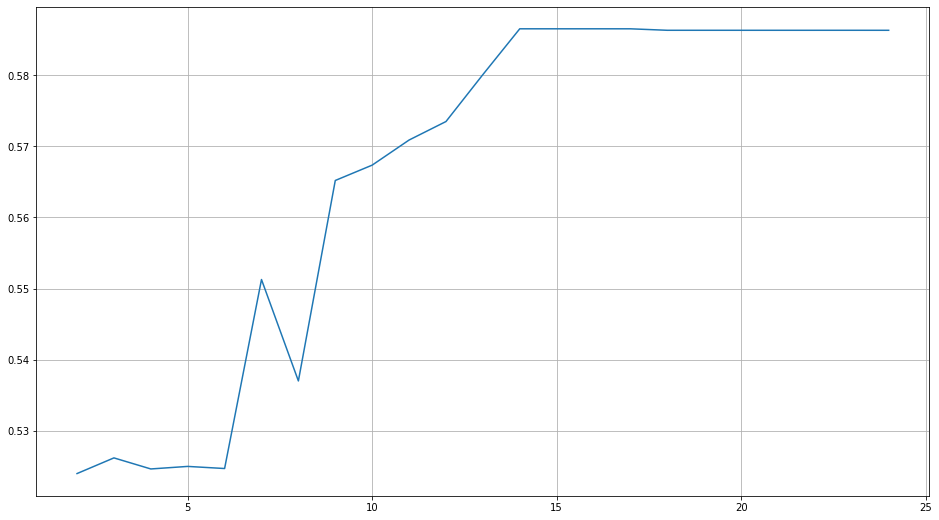

In [28]:
plt.figure(figsize=(16,9))
plt.plot(ns, roc_scores)
plt.grid()
plt.show()